# Image classification

This tutorial shows how to classify cats or dogs from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

Import Tensorflow and the Keras classes needed to construct our model.

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Begin by downloading the dataset. This tutorial uses a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [5]:
#_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

#path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join('PetsImages')

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [7]:
train_cats_dir = os.path.join(train_dir, 'Cat')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'Dog')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'Cat')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'Dog')  # directory with our validation dog pictures

### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2501
total validation dog images: 2501
--
Total training images: 20000
Total validation images: 5002


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [10]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [11]:
train_image_generator =ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    ) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

 Answers. First split the data into training and validation sets, then do data augmentation on the training set. You use your validation set to try to estimate how your method works on real world data, thus it should only contain real world data. Adding augmented data will not improve the accuracy of the validation.

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 19998 images belonging to 2 classes.


# Visualize Augmented Data

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


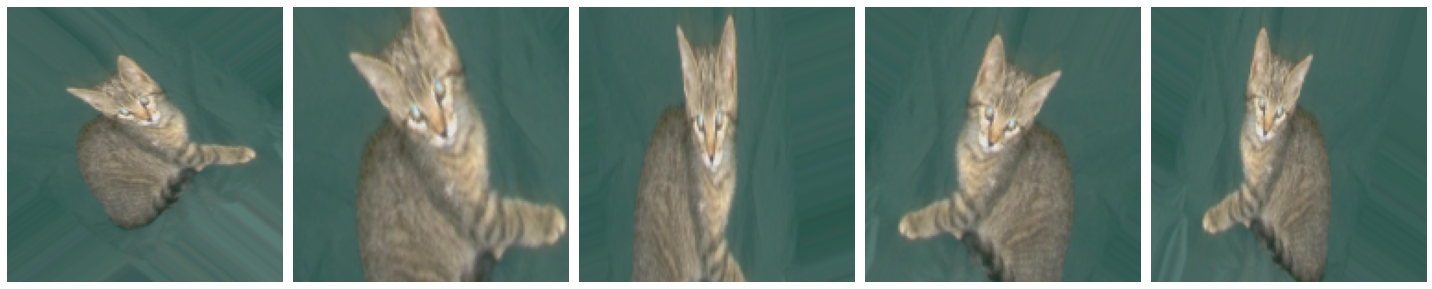

In [16]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

In [17]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 5002 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [18]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

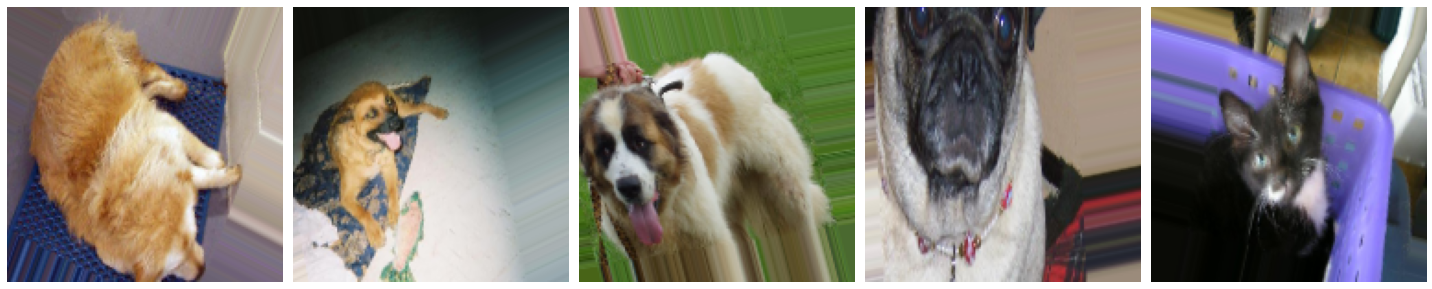

In [20]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [21]:
# apply dropout to avoid over fitting
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [24]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
DESIRED_ACCURACY = 0.9

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('acc') is not None and logs.get('acc') >= DESIRED_ACCURACY) :
            print('\nReached 90% accuracy so cancelling training!')
            self.model.stop_training = True

callbacks = myCallback()

In [31]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5,
    save_best_only=True)

early_stop= myCallback()


In [28]:
# class EarlyStoppingByAccuracy(Callback):
#     def __init__(self, monitor='accuracy', value=0.98, verbose=0):
#         super(Callback, self).__init__()
#         self.monitor = monitor
#         self.value = value
#         self.verbose = verbose

#     def on_epoch_end(self, epoch, logs={}):
#         current = logs.get(self.monitor)
#         if current is None:
#             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

#         if current >= self.value:
#             if self.verbose > 0:
#                 print("Epoch %05d: early stopping THR" % epoch)
#             self.model.stop_training = True

In [37]:
model.fit_generator(
    train_data_gen,
    steps_per_epoch=10,
    #total_train // batch_size,
    epochs=6 ,
    
    #epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,callbacks=[tensorboard_callback,cp_callback,early_stop]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 39 steps
Epoch 1/6
10/10 [==============================] - 77s 8s/step - loss: 0.6850 - accuracy: 0.5188 - val_loss: 0.6743 - val_accuracy: 0.5052
Epoch 2/6
 5/10 [==============>...............] - ETA: 15s - loss: 0.6848 - accuracy: 0.4980

UnknownError:  UnidentifiedImageError: cannot identify image file 'PetsImages/train/Dog/11702.jpg'
Traceback (most recent call last):

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/tensorflow_core/python/ops/script_ops.py", line 236, in __call__
    ret = func(*args)

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 110, in load_img
    img = pil_image.open(path)

  File "/home/haseeb/Documents/project_env/lib/python3.6/site-packages/PIL/Image.py", line 2862, in open
    "cannot identify image file %r" % (filename if filename else fp)

PIL.UnidentifiedImageError: cannot identify image file 'PetsImages/train/Dog/11702.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_distributed_function_1208]

Function call stack:
distributed_function


In [35]:
# 1)

# Save the model.
export_dir_tf = "/tmp/saved_model/"
tf.saved_model.save(model,export_dir_tf)
# Restoring the model
#restored_saved_model = keras.models.load_model(export_dir_tf)

# 2)

# Save the model

export_dir_k = "/tmp/keras/model.h5"
model.save(export_dir_k)

# Recreate the exact same model purely from the file
#model = keras.models.load_model(export_dir_k)


# 3)


# Convert the model.
export_dir_lite="/tmp/lite/"
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_lite)
tflite_model = converter.convert()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets


OSError: Unable to create file (unable to open file: name = '/tmp/keras/model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Visualize training results

Now visualize the results after training the network.

In [36]:
acc = model.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Restore Weight and Continue Training

In [ ]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))